In [27]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from spikingjelly.activation_based import neuron, functional, surrogate, layer
from tqdm import tqdm

In [28]:
class CSNN(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T

        self.conv_fc = nn.Sequential(
        layer.Conv2d(1, 64, kernel_size=3, padding=1, bias=False),
        layer.BatchNorm2d(64),
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        layer.MaxPool2d(2, 2),

        layer.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
        layer.BatchNorm2d(64),
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        layer.MaxPool2d(2, 2),

        layer.Flatten(),
        layer.Linear(64 * 7 * 7, 64 * 4 * 4, bias=False),
        neuron.IFNode(surrogate_function=surrogate.ATan()),

        layer.Linear(64 * 4 * 4, 10, bias=False),         
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr

class SNNLeNet(nn.Module):
    def __init__(self, T: int):
        super(SNNLeNet, self).__init__()
        self.T = T
        

        self.LeNet = nn.Sequential(
            layer.Conv2d(1, 6, kernel_size=5, padding=2, bias=False),
            layer.BatchNorm2d(6),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(6, 16, kernel_size=5, padding=0, bias=False),
            layer.BatchNorm2d(16),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(16, 120, kernel_size=5, padding=0, bias=False),
            layer.Flatten(),

            layer.Linear(120, 84, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.Linear(84, 10, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.LeNet(x_seq)
        fr = x_seq.mean(0)
        return fr

class SNNAlexNet(nn.Module):
    def __init__(self, T: int):
        super(SNNAlexNet, self).__init__()
        self.T = T
        

        self.features = nn.Sequential(
            layer.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2, stride=2),
 
            layer.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            layer.Dropout(),
            layer.Linear(64 * 7 * 7, 512),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
 
            layer.Dropout(),
            layer.Linear(512, 10),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.features(x_seq)
        x_seq = x_seq.view(x_seq.size(0), x_seq.size(1), -1)
        x_seq = self.classifier(x_seq)
        fr = x_seq.mean(0)
        return fr

In [29]:
T = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
total_epochs = 100
lr = 1e-3

In [30]:
simple_net = CSNN(T).to(device)
lenet = SNNLeNet(T).to(device)
alexnet = SNNAlexNet(T).to(device)
nets = [simple_net, lenet, alexnet]
nets_name = ['Simple CNN', 'LeNet', 'AlexNet']

train_set = torchvision.datasets.FashionMNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

test_set = torchvision.datasets.FashionMNIST(
    root='./mnist',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True
)

simple_optimizer = torch.optim.Adam(simple_net.parameters(), lr=lr)
lenet_optimizer = torch.optim.Adam(lenet.parameters(), lr=lr)
alexnet_optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)
opts = [simple_optimizer, lenet_optimizer, alexnet_optimizer]

simple_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(simple_optimizer, total_epochs)
lenet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(lenet_optimizer, total_epochs)
alexnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(alexnet_optimizer, total_epochs)
schedulers = [simple_scheduler, lenet_scheduler, alexnet_scheduler]

In [31]:
train_losses = [[], [], []]
train_accuracies = [[], [], []]
test_losses = [[], [], []]
test_accuracies = [[], [], []]

for i in range(3):
    print(f'Training {nets_name[i]}')
    net = nets[i]
    optimizer = opts[i]
    scheduler = schedulers[i]

    for epoch in range(1, total_epochs + 1):
        print(f'Epoch {epoch}/{total_epochs}')

        net.train()
        train_loss = 0
        train_acc = 0
        train_samples = 0

        # pbar = tqdm(train_data_loader, desc=f'Train {epoch}/{total_epochs}', leave=False)
        for img, label in train_data_loader:
            optimizer.zero_grad()          #reset optimizer
            img = img.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, 10).float() #one-hot encoding the label to a vector

            # print(img.shape)
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()
            functional.reset_net(net)

            train_samples += label.numel()
            train_loss += loss.item() * label.numel()
            train_acc += (out_fr.argmax(1) == label).float().sum().item()

            functional.reset_net(net)

        train_loss /= train_samples
        train_acc /= train_samples
        train_losses[i].append(train_loss)
        train_accuracies[i].append(train_acc)
        print(f'Train Loss ={train_loss: .4f}, Train Accuracy ={train_acc: .4f}')

        scheduler.step()

        net.eval()
        test_loss = 0
        test_acc = 0
        test_samples = 0
        with torch.no_grad():
            # pbar = tqdm(test_data_loader, desc=f'Test {epoch}/{total_epochs}', leave=False)
            for img, label in test_data_loader:
                img = img.to(device)
                label = label.to(device)
                label_onehot = F.one_hot(label, 10).float()
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)

                test_samples += label.numel()
                test_loss += loss.item() * label.numel()
                test_acc += (out_fr.argmax(1) == label).float().sum().item()
                functional.reset_net(net)

        test_loss /= test_samples
        test_acc /= test_samples
        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_acc)
        print(f'Test Loss ={test_loss: .4f}, Test Accuracy ={test_acc: .4f}')


Training Simple CNN
Epoch 1/100
Train Loss = 0.0276, Train Accuracy = 0.8180
Test Loss = 0.0186, Test Accuracy = 0.8813
Epoch 2/100
Train Loss = 0.0166, Train Accuracy = 0.8929
Test Loss = 0.0168, Test Accuracy = 0.8964
Epoch 3/100
Train Loss = 0.0145, Train Accuracy = 0.9060
Test Loss = 0.0148, Test Accuracy = 0.9029
Epoch 4/100
Train Loss = 0.0133, Train Accuracy = 0.9145
Test Loss = 0.0146, Test Accuracy = 0.9060
Epoch 5/100
Train Loss = 0.0124, Train Accuracy = 0.9207
Test Loss = 0.0135, Test Accuracy = 0.9110
Epoch 6/100
Train Loss = 0.0114, Train Accuracy = 0.9273
Test Loss = 0.0134, Test Accuracy = 0.9117
Epoch 7/100
Train Loss = 0.0109, Train Accuracy = 0.9310
Test Loss = 0.0134, Test Accuracy = 0.9144
Epoch 8/100
Train Loss = 0.0101, Train Accuracy = 0.9373
Test Loss = 0.0140, Test Accuracy = 0.9083
Epoch 9/100
Train Loss = 0.0095, Train Accuracy = 0.9411
Test Loss = 0.0133, Test Accuracy = 0.9098
Epoch 10/100
Train Loss = 0.0089, Train Accuracy = 0.9454
Test Loss = 0.0124, Te

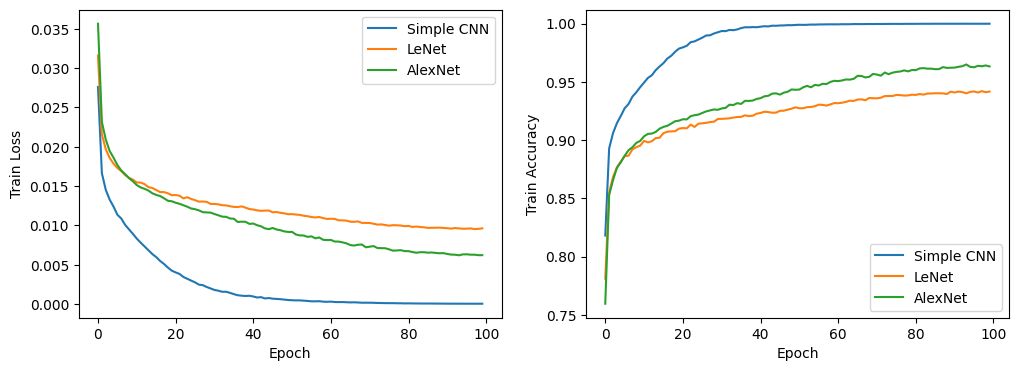

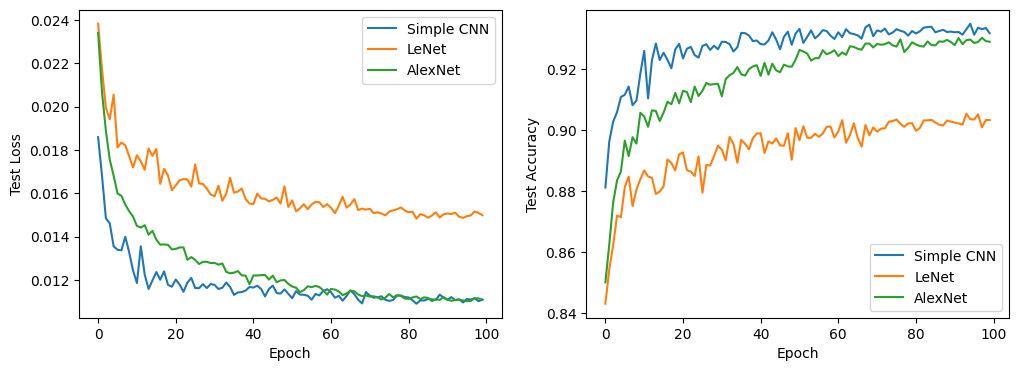

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in range(3):
    plt.plot(train_losses[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(122)
for i in range(3):
    plt.plot(train_accuracies[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in range(3):
    plt.plot(test_losses[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.subplot(122)
for i in range(3):
    plt.plot(test_accuracies[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()